In [532]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score,classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.base import BaseEstimator

# Time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In [533]:
file_path = '/Users/edocampione/Desktop/Meng Engineering Science/4YP/scripts/dati_trattati.csv' # cleaned data
df = pd.read_csv(file_path)
df['datadate'] = pd.to_datetime(df['datadate'])
df['datadate'] = df['datadate'] + pd.offsets.QuarterEnd(0)

df = df.dropna(subset=['relative_quarterly_return'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14322 entries, 1 to 15338
Data columns (total 48 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   gvkey                           14322 non-null  int64         
 1   datadate                        14322 non-null  datetime64[ns]
 2   tic                             14322 non-null  object        
 3   actq                            14322 non-null  float64       
 4   ancq                            14322 non-null  float64       
 5   epsfxq                          14302 non-null  float64       
 6   lctq                            14322 non-null  float64       
 7   ltq                             14322 non-null  float64       
 8   revtq                           14322 non-null  float64       
 9   capxy                           13783 non-null  float64       
 10  roa                             14289 non-null  float64       
 11  ro

In [534]:
drop_features = ['capxy', 'cfm', 'PEG_trailing', 'de_ratio', 'divyield']
df = df.drop(drop_features, 1)
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11212 entries, 32 to 15337
Data columns (total 43 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   gvkey                           11212 non-null  int64         
 1   datadate                        11212 non-null  datetime64[ns]
 2   tic                             11212 non-null  object        
 3   actq                            11212 non-null  float64       
 4   ancq                            11212 non-null  float64       
 5   epsfxq                          11212 non-null  float64       
 6   lctq                            11212 non-null  float64       
 7   ltq                             11212 non-null  float64       
 8   revtq                           11212 non-null  float64       
 9   roa                             11212 non-null  float64       
 10  roe                             11212 non-null  float64       
 11  p

In [535]:
# Find the unique number of stocks in the dataframe
unique_gvkeys = df['tic'].unique()

# Print the result
print(f"Number of unique gvkeys: {len(unique_gvkeys)}")
print(unique_gvkeys)


Number of unique gvkeys: 80
['AAPL' 'ABT' 'ADBE' 'ADM' 'AMD' 'AMGN' 'AMT' 'AMZN' 'APD' 'BA' 'BAX'
 'BMY' 'CAT' 'CL' 'CME' 'COP' 'COST' 'CSCO' 'CTSH' 'CVS' 'CVX' 'DIS' 'ECL'
 'EQIX' 'EXC' 'EXPE' 'F' 'FDX' 'FIS' 'GE' 'GOOGL' 'HCA' 'HD' 'IBM' 'INTC'
 'JBL' 'JNJ' 'KMB' 'KO' 'LLY' 'LMT' 'LUV' 'MA' 'MCD' 'META' 'MMC' 'MMM'
 'MRK' 'MSFT' 'MU' 'NFLX' 'NKE' 'NOC' 'NVDA' 'OXY' 'PFE' 'PG' 'PPL' 'PYPL'
 'QCOM' 'REGN' 'RJF' 'RTX' 'SBUX' 'SPGI' 'STZ' 'T' 'TGT' 'TMO' 'TSLA'
 'TSN' 'UNH' 'UPS' 'V' 'VZ' 'WBA' 'WDC' 'WMT' 'XOM' 'ZTS']


In [536]:
df = df.dropna()
df = df.sort_values(by=['datadate'])

unique_gvkeys = df['tic'].unique()

# Print the result
print(f"Number of unique gvkeys: {len(unique_gvkeys)}")

df.info()

Number of unique gvkeys: 80
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11212 entries, 172 to 3737
Data columns (total 43 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   gvkey                           11212 non-null  int64         
 1   datadate                        11212 non-null  datetime64[ns]
 2   tic                             11212 non-null  object        
 3   actq                            11212 non-null  float64       
 4   ancq                            11212 non-null  float64       
 5   epsfxq                          11212 non-null  float64       
 6   lctq                            11212 non-null  float64       
 7   ltq                             11212 non-null  float64       
 8   revtq                           11212 non-null  float64       
 9   roa                             11212 non-null  float64       
 10  roe                             11212 non

In [537]:
tickers_to_drop = ['AMT', 'CTSH', 'GOOGL', 'META', 'PYPL', 'RJF', 'TSLA', 'ZTS']

df = df[~df['tic'].isin(tickers_to_drop)]

In [538]:
train_start_date = '1970-03-31'
valid_start_date = '2010-03-31'
test_start_date = '2013-03-31'
end_date = '2023-09-30'

df = df.sort_values(by=['datadate'])

train_df = df[(df['datadate'] >= train_start_date) & (df['datadate'] < valid_start_date)]
valid_df = df[(df['datadate'] >= valid_start_date) & (df['datadate'] < test_start_date)]
test_df = df[(df['datadate'] >= test_start_date) & (df['datadate'] < end_date)]

test_df = test_df.sort_values(by=['datadate', 'next_prccq_change'], ascending=[True, False])
test_df.head(10)


,gvkey,datadate,tic,actq,ancq,epsfxq,lctq,ltq,revtq,roa,...,curr_ratio_change,ptb_change,relative_quarterly_return,next_relative_quarterly_return,spindx,spindx_change,next_spindx_change,prccq,prccq_change,next_prccq_change
1253,1161,2013-03-31,AMD,0.032230,-0.159078,-0.698413,-0.054402,-0.023108,-0.058009,0.023,...,-0.008020,1.083812,-0.032845,0.566207,1562.17,0.095345,0.033793,2.550,0.062500,0.600000
10115,7343,2013-03-31,MU,0.009219,-0.023309,0.037037,-0.009822,0.012073,0.133043,0.107,...,-0.014717,0.297872,0.334470,0.318003,1514.68,0.069553,0.076623,8.375,0.404023,0.394627
11978,23812,2013-03-31,REGN,0.083838,0.107948,-0.779412,0.206017,0.041366,0.060448,0.383,...,-0.205994,0.289679,-0.064171,0.241016,1562.17,0.095345,0.033793,176.403,0.031174,0.274808
3228,149070,2013-03-31,CME,0.410638,-0.000707,0.420000,0.547441,0.197396,0.087305,0.049,...,-0.004367,0.134783,0.116615,0.202977,1562.17,0.095345,0.033793,61.410,0.211960,0.236769
14621,11399,2013-03-31,WDC,0.022997,-0.024726,0.176471,-0.030066,-0.031327,-0.015690,0.266,...,0.087776,0.291424,0.088228,0.200846,1562.17,0.095345,0.033793,50.290,0.183573,0.234639
9959,12141,2013-03-31,MSFT,0.044098,0.037638,-0.052632,0.000595,0.023348,-0.045069,0.256,...,0.002184,0.186091,-0.024386,0.173863,1562.17,0.095345,0.033793,28.605,0.070959,0.207656
13004,2710,2013-03-31,STZ,-0.003789,-0.115575,-0.258621,-0.139502,-0.138732,-0.092581,0.091,...,0.359567,0.514735,0.163446,0.121613,1514.68,0.069553,0.076623,44.240,0.232999,0.198237
2121,2285,2013-03-31,BA,0.038057,-0.019945,0.125000,0.015206,-0.000506,-0.152856,0.094,...,-0.008634,0.015841,0.043854,0.159451,1562.17,0.095345,0.033793,85.850,0.139199,0.193244
10580,7985,2013-03-31,NOC,-0.065062,-0.004573,-0.051402,-0.082728,-0.034294,-0.057443,0.139,...,0.002886,0.249847,-0.057316,0.146535,1562.17,0.095345,0.033793,70.150,0.038029,0.180328
13375,3813,2013-03-31,TGT,-0.113923,0.022230,0.531250,-0.106818,-0.048816,0.342430,0.155,...,-0.026667,0.125000,-0.113256,0.101628,1498.11,0.060864,0.066390,60.410,-0.052392,0.168019


In [539]:
results = test_df[['datadate', 'tic', 'next_prccq_change', 'next_relative_quarterly_return']].copy()

drop_cols = ['gvkey', 'datadate', 'tic', 'spindx', 'spindx_change', 'next_spindx_change', 'prccq', 'prccq_change', 'next_prccq_change']

train_df = train_df.drop(drop_cols, 1)
valid_df = valid_df.drop(drop_cols, 1)
test_df  = test_df.drop(drop_cols, 1)

train_df.head()

,actq,ancq,epsfxq,lctq,ltq,revtq,roa,roe,pe_inc,pcf,...,gpm_change,evm_change,cfm_change,npm_change,PEG_trailing_change,de_ratio_change,curr_ratio_change,ptb_change,relative_quarterly_return,next_relative_quarterly_return
172,0.0,0.0,-0.115385,0.0,0.0,-0.016251,0.224,0.556,25.408,34.228,...,0.0,0.000000,0.000000,0.000000,-0.295597,0.0,0.0,-0.177037,-0.016088,0.028255
15082,0.0,0.0,-0.013423,0.0,0.0,0.036061,0.170,0.032,11.749,6.020,...,0.0,-0.028041,-0.106383,-0.108434,0.237403,0.0,0.0,0.050788,-0.046479,0.144996
5213,0.0,0.0,-0.135338,0.0,0.0,-0.172254,0.211,0.034,9.079,3.284,...,0.0,0.354212,-0.326087,-0.054054,0.148148,0.0,0.0,-0.005464,0.138857,0.147681
1734,0.0,0.0,0.181818,0.0,0.0,0.089057,0.146,0.097,15.323,14.417,...,0.0,0.000000,0.000000,-0.016949,-0.363201,0.0,0.0,-0.095171,0.130826,0.071186
4912,0.0,0.0,0.304444,0.0,0.0,0.135055,0.112,0.110,11.028,5.864,...,0.0,0.000000,-0.011628,-0.013699,0.000000,0.0,0.0,-0.114448,0.036812,-0.002057


In [540]:
y_train = train_df['next_relative_quarterly_return'].copy()
X_train = train_df.drop(['next_relative_quarterly_return',], 1)

y_valid = valid_df['next_relative_quarterly_return'].copy()
X_valid = valid_df.drop(['next_relative_quarterly_return',], 1)

y_test  = test_df['next_relative_quarterly_return'].copy()
X_test  = test_df.drop(['next_relative_quarterly_return',], 1)

X_train.head()

,actq,ancq,epsfxq,lctq,ltq,revtq,roa,roe,pe_inc,pcf,...,debt_ebitda_change,gpm_change,evm_change,cfm_change,npm_change,PEG_trailing_change,de_ratio_change,curr_ratio_change,ptb_change,relative_quarterly_return
172,0.0,0.0,-0.115385,0.0,0.0,-0.016251,0.224,0.556,25.408,34.228,...,0.000000,0.0,0.000000,0.000000,0.000000,-0.295597,0.0,0.0,-0.177037,-0.016088
15082,0.0,0.0,-0.013423,0.0,0.0,0.036061,0.170,0.032,11.749,6.020,...,-0.000895,0.0,-0.028041,-0.106383,-0.108434,0.237403,0.0,0.0,0.050788,-0.046479
5213,0.0,0.0,-0.135338,0.0,0.0,-0.172254,0.211,0.034,9.079,3.284,...,0.371212,0.0,0.354212,-0.326087,-0.054054,0.148148,0.0,0.0,-0.005464,0.138857
1734,0.0,0.0,0.181818,0.0,0.0,0.089057,0.146,0.097,15.323,14.417,...,0.000000,0.0,0.000000,0.000000,-0.016949,-0.363201,0.0,0.0,-0.095171,0.130826
4912,0.0,0.0,0.304444,0.0,0.0,0.135055,0.112,0.110,11.028,5.864,...,0.000000,0.0,0.000000,-0.011628,-0.013699,0.000000,0.0,0.0,-0.114448,0.036812


In [541]:
# Scaling
scaler = MinMaxScaler()

# Fit the scaler on the training/validation data
X_train_scaled = scaler.fit_transform(X_train)

# Now apply the same scaling to the val/test data using the already fitted scaler
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled data back to DataFrame for consistency
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=X_valid.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

X_train_scaled.head()

,actq,ancq,epsfxq,lctq,ltq,revtq,roa,roe,pe_inc,pcf,...,debt_ebitda_change,gpm_change,evm_change,cfm_change,npm_change,PEG_trailing_change,de_ratio_change,curr_ratio_change,ptb_change,relative_quarterly_return
0,0.15915,0.15647,0.600363,0.14011,0.103656,0.085120,0.812405,0.307713,0.563323,0.503678,...,0.305676,0.28277,0.505650,0.543478,0.892899,0.114620,0.075733,0.263092,0.022231,0.117021
1,0.15915,0.15647,0.600801,0.14011,0.103656,0.089930,0.796067,0.301351,0.555988,0.461638,...,0.305671,0.28277,0.505401,0.541744,0.892514,0.114802,0.075733,0.263092,0.029147,0.112010
2,0.15915,0.15647,0.600278,0.14011,0.103656,0.070774,0.808472,0.301376,0.554554,0.457561,...,0.307639,0.28277,0.508806,0.538162,0.892708,0.114771,0.075733,0.263092,0.027439,0.142569
3,0.15915,0.15647,0.601639,0.14011,0.103656,0.094803,0.788805,0.302140,0.557907,0.474153,...,0.305676,0.28277,0.505650,0.543478,0.892839,0.114597,0.075733,0.263092,0.024716,0.141245
4,0.15915,0.15647,0.602165,0.14011,0.103656,0.099033,0.778517,0.302298,0.555600,0.461406,...,0.305676,0.28277,0.505650,0.543289,0.892851,0.114721,0.075733,0.263092,0.024131,0.125743


In [542]:
'''

model = xgb.XGBRanker(
    objective="rank:pairwise",  
    eval_metric="ndcg",
    learning_rate=0.05,
    max_depth=8,
    gamma=0.1,
    random_state=42,
    n_estimators=300
)

# Fit model with `group`
model.fit(X_train, y_train, group=train_group)

'''

'\n\nmodel = xgb.XGBRanker(\n    objective="rank:pairwise",  \n    eval_metric="ndcg",\n    learning_rate=0.05,\n    max_depth=8,\n    gamma=0.1,\n    random_state=42,\n    n_estimators=300\n)\n\n# Fit model with `group`\nmodel.fit(X_train, y_train, group=train_group)\n\n'

In [543]:


%%time

parameters = {
    'n_estimators': [300],
    'learning_rate': [0.1],
    'max_depth': [8],
    'gamma': [0.1],
    'random_state': [42]
}

eval_set = [(X_train_scaled, y_train), (X_valid_scaled, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train_scaled, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')



/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[21:24:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[21:24:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[21:24:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[21:24:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[21:24:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { 

Best params: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 300, 'random_state': 42}
Best validation score = 0.2495428750947096
CPU times: user 17.1 s, sys: 924 ms, total: 18 s
Wall time: 6.87 s


In [544]:

%%time

model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train_scaled, y_train, eval_set=eval_set, verbose=False)



CPU times: user 5.42 s, sys: 383 ms, total: 5.8 s
Wall time: 1.52 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

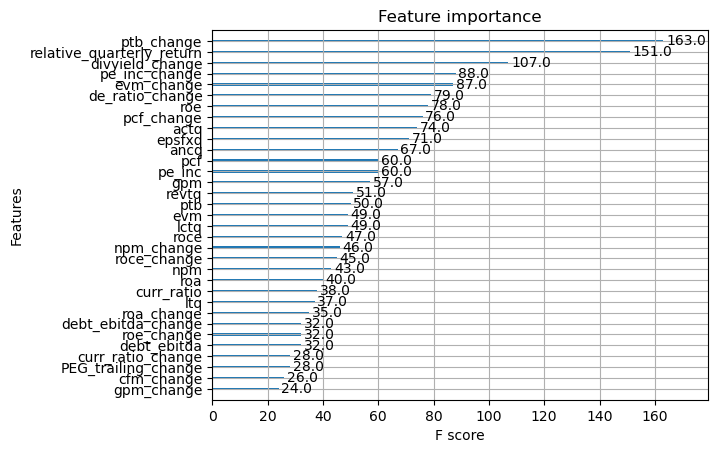

In [545]:
plot_importance(model);

# Get the feature importance scores
importance = model.get_booster().get_score(importance_type='weight')

# Sort the features by importance
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

# Extract the most important features as a list of feature names (strings)
important_features = [feature for feature, score in sorted_importance[:5]]


In [546]:
y_train_pred = model.predict(X_train_scaled)
y_valid_pred = model.predict(X_valid_scaled)
y_test_pred = model.predict(X_test_scaled)

# Classifier
y_train_pred_binary = (y_train_pred >= 0).astype(int)
y_valid_pred_binary = (y_valid_pred >= 0).astype(int)
y_test_pred_binary = (y_test_pred >= 0).astype(int)

y_train_binary = (y_train >= 0).astype(int)
y_valid_binary = (y_valid >= 0).astype(int)
y_test_binary = (y_test >= 0).astype(int)

print(y_test_pred)

print(classification_report(y_train_binary, y_train_pred_binary))



[ 0.44004095  0.08845297  0.3230055  ... -0.0063904   0.01361869
 -0.02671743]
              precision    recall  f1-score   support

           0       0.73      0.67      0.70      3460
           1       0.73      0.78      0.76      3936

    accuracy                           0.73      7396
   macro avg       0.73      0.73      0.73      7396
weighted avg       0.73      0.73      0.73      7396



In [547]:
results['y_pred'] = y_test_pred
results1 = results.sort_values(by=['datadate', 'y_pred'], ascending=[True, False])

results1.head(5)



,datadate,tic,next_prccq_change,next_relative_quarterly_return,y_pred
1253,2013-03-31,AMD,0.600000,0.566207,0.440041
11978,2013-03-31,REGN,0.274808,0.241016,0.323005
13004,2013-03-31,STZ,0.198237,0.121613,0.236625
10200,2013-03-31,NFLX,0.115226,0.081433,0.159093
8319,2013-03-31,LMT,0.123705,0.089912,0.153238


In [548]:
def softmax_weighted_return(df, sort_col, target_col, n=5, largest=True):
    if largest:
        selected = df.nlargest(n, sort_col)
    else:
        selected = df.nsmallest(n, sort_col)
    # Compute softmax weights from the predicted scores:
    e_scores = np.exp(selected[sort_col])
    weights = e_scores / e_scores.sum()
    return (selected[target_col] * weights).sum()

def exponential_weighted_return(df, sort_col, target_col, n=10, largest=True, alpha=0.5):
    if largest:
        selected = df.nlargest(n, sort_col)
    else:
        selected = df.nsmallest(n, sort_col)
    selected = selected.sort_values(by=sort_col, ascending=not largest).copy()
    selected['rank'] = range(1, len(selected) + 1)
    # Exponential weights: weight = exp(-alpha * (rank - 1))
    selected['weight'] = np.exp(-alpha * (selected['rank'] - 1))
    selected['weight'] /= selected['weight'].sum()  # Normalize weights
    return (selected[target_col] * selected['weight']).sum()


# Baseline aggregation remains unchanged.
df_avg = results.groupby('datadate').agg(
    stocks=('next_prccq_change', 'size'),
    baseline=('next_prccq_change', 'mean')
).reset_index()

# For the predicted top 10, weight by predicted returns ('pred_rank_score')
df_avg['top_10'] = results.groupby('datadate').apply(
    lambda group: exponential_weighted_return(
        group,
        sort_col='y_pred',
        target_col='next_prccq_change',
        largest=True
    )
).reset_index(level=0, drop=True)

# For the ideal top 10, weight by the actual returns
df_avg['top_10_ideal'] = results.groupby('datadate').apply(
    lambda group: exponential_weighted_return(
        group,
        sort_col='next_prccq_change',
        target_col='next_prccq_change',
        largest=True
    )
).reset_index(level=0, drop=True)

# For the predicted bottom 10, weight by predicted returns
df_avg['bottom_10'] = results.groupby('datadate').apply(
    lambda group: exponential_weighted_return(
        group,
        sort_col='y_pred',
        target_col='next_prccq_change',
        largest=False
    )
).reset_index(level=0, drop=True)

# For the ideal bottom 10, weight by the actual returns
df_avg['bottom_10_ideal'] = results.groupby('datadate').apply(
    lambda group: exponential_weighted_return(
        group,
        sort_col='next_prccq_change',
        target_col='next_prccq_change',
        largest=False
    )
).reset_index(level=0, drop=True)

# Display the first 100 rows of the new dataframe
df_avg.head(10)


,datadate,stocks,baseline,top_10,top_10_ideal,bottom_10,bottom_10_ideal
0,2013-03-31,63,0.065437,0.363120,0.421077,-0.017599,-0.124256
1,2013-06-30,64,0.059808,0.135495,0.354006,-0.051917,-0.093581
2,2013-09-30,66,0.110123,0.257526,0.412804,-0.066567,-0.106066
3,2013-12-31,66,0.032754,0.054885,0.256265,-0.069344,-0.120828
4,2014-03-31,66,0.039382,0.124978,0.215892,0.055244,-0.098166
5,2014-06-30,67,0.022670,0.169408,0.230542,-0.067449,-0.145873
6,2014-09-30,65,0.054048,0.181808,0.238110,-0.054880,-0.189307
7,2014-12-31,64,0.027150,0.131051,0.206037,-0.064309,-0.152242
8,2015-03-31,65,0.009599,0.124979,0.322730,-0.120439,-0.169087
9,2015-06-30,63,-0.056546,0.092258,0.143413,-0.239675,-0.309548


In [549]:
for portfolio in ['baseline', 'top_10', 'bottom_10']:

    mean_return = df_avg[portfolio].mean()

    # Calculate the standard deviation of the returns of the top 10 portfolio
    std_return = df_avg[portfolio].std()

    # Assuming the risk-free rate is 0 (if you have a specific risk-free rate, replace 0 with that value)
    risk_free_rate = 0.025

    # Calculate the Sharpe ratio
    sharpe_ratio = (mean_return - risk_free_rate) / std_return

    # Print the Sharpe ratio
    print(f"Mean quarterly return of the {portfolio} portfolio: {mean_return}")
    print(f"Sharpe Ratio of the {portfolio} portfolio: {sharpe_ratio}")
    print("")

Mean quarterly return of the baseline portfolio: 0.03360167684373077
Sharpe Ratio of the baseline portfolio: 0.14378314191983466

Mean quarterly return of the top_10 portfolio: 0.20581700842274153
Sharpe Ratio of the top_10 portfolio: 1.319828079735179

Mean quarterly return of the bottom_10 portfolio: -0.10395251124719497
Sharpe Ratio of the bottom_10 portfolio: -1.2169011575852147



In [550]:
import plotly.graph_objects as go

# Assuming you have a dataframe 'df_avg' with columns 'datadate', 'baseline_portfolio', and 'top_10'

# Calculate the cumulative return for both portfolios
df_avg['baseline_cum_return'] = (1 + df_avg['baseline']).cumprod()
df_avg['top_10_cum_return'] = (1 + df_avg['top_10']).cumprod()

# Calculate the value over time of a $1,000 investment
initial_investment = 1000
df_avg['baseline_value'] = initial_investment * df_avg['baseline_cum_return']
df_avg['top_10_value'] = initial_investment * df_avg['top_10_cum_return']

# Create the plot
fig = go.Figure()

# Add baseline portfolio trace
fig.add_trace(go.Scatter(x=df_avg['datadate'], y=df_avg['baseline_value'],
                         mode='lines', name='Baseline Portfolio'))

# Add top_10 portfolio trace
fig.add_trace(go.Scatter(x=df_avg['datadate'], y=df_avg['top_10_value'],
                         mode='lines', name='Top 10 Portfolio'))

# Update the layout
fig.update_layout(
    title='Portfolio Value Over Time ($1,000 Investment)',
    xaxis_title='Date',
    yaxis_title='Portfolio Value ($)',
)

# Show the plot
fig.show()


In [551]:
train_df = train_df[important_features + ['next_relative_quarterly_return']]
valid_df = valid_df[important_features + ['next_relative_quarterly_return']]
test_df  = test_df[important_features + ['next_relative_quarterly_return']]

y_train = train_df['next_relative_quarterly_return'].copy()
X_train = train_df.drop(['next_relative_quarterly_return'], 1)

y_valid = valid_df['next_relative_quarterly_return'].copy()
X_valid = valid_df.drop(['next_relative_quarterly_return'], 1)

y_test  = test_df['next_relative_quarterly_return'].copy()
X_test  = test_df.drop(['next_relative_quarterly_return'], 1)

# Scaling
scaler = MinMaxScaler()

# Fit the scaler on the training/validation data
X_train_scaled = scaler.fit_transform(X_train)

# Now apply the same scaling to the val/test data using the already fitted scaler
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled data back to DataFrame for consistency
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=X_valid.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

X_train_scaled.head()

,ptb_change,relative_quarterly_return,divyield_change,pe_inc_change,evm_change
0,0.022231,0.117021,0.166364,0.548851,0.505650
1,0.029147,0.112010,0.128508,0.549597,0.505401
2,0.027439,0.142569,0.136216,0.550186,0.508806
3,0.024716,0.141245,0.149920,0.549042,0.505650
4,0.024131,0.125743,0.153609,0.545904,0.505650


In [552]:
params = {
    'objective': 'reg:squarederror',
    'max_depth': 8,
    'learning_rate': 0.1,
    'n_estimators': 300,
    'gamma': 0.1,
    'random_state': 42
}
eval_set = [(X_train_scaled, y_train), (X_valid_scaled, y_valid)]
model = xgb.XGBRegressor(**params)
model.fit(X_train_scaled, y_train, eval_set=eval_set, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [553]:
# Predictions
y_train_pred = model.predict(X_train_scaled)
y_valid_pred = model.predict(X_valid_scaled)
y_test_pred = model.predict(X_test_scaled)

# Classifier
y_train_pred_binary = (y_train_pred >= 0).astype(int)
y_valid_pred_binary = (y_valid_pred >= 0).astype(int)
y_test_pred_binary = (y_test_pred >= 0).astype(int)

y_train_binary = (y_train >= 0).astype(int)
y_valid_binary = (y_valid >= 0).astype(int)
y_test_binary = (y_test >= 0).astype(int)

print(y_test_pred)

print(classification_report(y_test_binary, y_test_pred_binary))


[ 0.49604607  0.20148762  0.25936222 ... -0.01148643  0.01150399
 -0.01914257]
              precision    recall  f1-score   support

           0       0.73      0.60      0.66      1373
           1       0.65      0.78      0.71      1349

    accuracy                           0.69      2722
   macro avg       0.69      0.69      0.68      2722
weighted avg       0.69      0.69      0.68      2722



In [554]:
results['y_pred_import'] = y_test_pred
results = results.sort_values(by=['datadate', 'y_pred'], ascending=[True, False])

results.head(5)

,datadate,tic,next_prccq_change,next_relative_quarterly_return,y_pred,y_pred_import
1253,2013-03-31,AMD,0.600000,0.566207,0.440041,0.496046
11978,2013-03-31,REGN,0.274808,0.241016,0.323005,0.259362
13004,2013-03-31,STZ,0.198237,0.121613,0.236625,0.229056
10200,2013-03-31,NFLX,0.115226,0.081433,0.159093,-0.073912
8319,2013-03-31,LMT,0.123705,0.089912,0.153238,0.108578


In [555]:
def softmax_weighted_return(df, sort_col, target_col, n=5, largest=True):
    if largest:
        selected = df.nlargest(n, sort_col)
    else:
        selected = df.nsmallest(n, sort_col)
    # Compute softmax weights from the predicted scores:
    e_scores = np.exp(selected[sort_col])
    weights = e_scores / e_scores.sum()
    return (selected[target_col] * weights).sum()

def exponential_weighted_return(df, sort_col, target_col, n=10, largest=True, alpha=0.5):
    if largest:
        selected = df.nlargest(n, sort_col)
    else:
        selected = df.nsmallest(n, sort_col)
    selected = selected.sort_values(by=sort_col, ascending=not largest).copy()
    selected['rank'] = range(1, len(selected) + 1)
    # Exponential weights: weight = exp(-alpha * (rank - 1))
    selected['weight'] = np.exp(-alpha * (selected['rank'] - 1))
    selected['weight'] /= selected['weight'].sum()  # Normalize weights
    return (selected[target_col] * selected['weight']).sum()

# For the predicted top 10, weight by predicted returns ('pred_rank_score')
df_avg['top_10_import'] = results.groupby('datadate').apply(
    lambda group: exponential_weighted_return(
        group,
        sort_col='y_pred_import',
        target_col='next_prccq_change',
        largest=True
    )
).reset_index(level=0, drop=True)

# For the predicted bottom 10, weight by predicted returns
df_avg['bottom_10_import'] = results.groupby('datadate').apply(
    lambda group: exponential_weighted_return(
        group,
        sort_col='y_pred_import',
        target_col='next_prccq_change',
        largest=False
    )
).reset_index(level=0, drop=True)

# Display the first 100 rows of the new dataframe
df_avg.head(10)


,datadate,stocks,baseline,top_10,top_10_ideal,bottom_10,bottom_10_ideal,baseline_cum_return,top_10_cum_return,baseline_value,top_10_value,top_10_import,bottom_10_import
0,2013-03-31,63,0.065437,0.363120,0.421077,-0.017599,-0.124256,1.065437,1.363120,1065.437196,1363.120085,0.390619,0.032750
1,2013-06-30,64,0.059808,0.135495,0.354006,-0.051917,-0.093581,1.129159,1.547817,1129.158556,1547.816638,0.136545,-0.062104
2,2013-09-30,66,0.110123,0.257526,0.412804,-0.066567,-0.106066,1.253505,1.946420,1253.504932,1946.420081,0.224191,-0.036317
3,2013-12-31,66,0.032754,0.054885,0.256265,-0.069344,-0.120828,1.294563,2.053250,1294.562795,2053.250071,0.134232,-0.066309
4,2014-03-31,66,0.039382,0.124978,0.215892,0.055244,-0.098166,1.345545,2.309860,1345.544908,2309.860341,0.090021,0.083753
5,2014-06-30,67,0.022670,0.169408,0.230542,-0.067449,-0.145873,1.376049,2.701170,1376.048850,2701.169891,0.145642,-0.052598
6,2014-09-30,65,0.054048,0.181808,0.238110,-0.054880,-0.189307,1.450421,3.192263,1450.420942,3192.263190,0.201162,-0.129466
7,2014-12-31,64,0.027150,0.131051,0.206037,-0.064309,-0.152242,1.489800,3.610614,1489.799908,3610.614058,0.092458,-0.069410
8,2015-03-31,65,0.009599,0.124979,0.322730,-0.120439,-0.169087,1.504101,4.061865,1504.100683,4061.865451,0.117659,-0.147248
9,2015-06-30,63,-0.056546,0.092258,0.143413,-0.239675,-0.309548,1.419049,4.436607,1419.049198,4436.606648,0.097912,-0.215075


In [556]:
for portfolio in ['top_10', 'top_10_import']:

    mean_return = df_avg[portfolio].mean()

    # Calculate the standard deviation of the returns of the top 10 portfolio
    std_return = df_avg[portfolio].std()

    # Assuming the risk-free rate is 0 (if you have a specific risk-free rate, replace 0 with that value)
    risk_free_rate = 0.025

    # Calculate the Sharpe ratio
    sharpe_ratio = (mean_return - risk_free_rate) / std_return

    # Print the Sharpe ratio
    print(f"Mean quarterly return of the {portfolio} portfolio: {mean_return}")
    print(f"Sharpe Ratio of the {portfolio} portfolio: {sharpe_ratio}")
    print("")

Mean quarterly return of the top_10 portfolio: 0.20581700842274153
Sharpe Ratio of the top_10 portfolio: 1.319828079735179

Mean quarterly return of the top_10_import portfolio: 0.2000897774134724
Sharpe Ratio of the top_10_import portfolio: 1.5004188408005699

